<a href="https://colab.research.google.com/github/Michael-Jimenez-C/CieCom2/blob/main/proyecto_CII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import sympy as sp
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from sympy.physics.control.lti import TransferFunction
from sympy.series.formal import Coeff
from sympy.abc import t,s

In [ ]:
class Cuarto:
  def __init__(self,capacitancia,temperatura,fuente=0,Rfuente=1):
    t=sp.symbols("t")
    self.temperatura=temperatura
    self.adyacentes=[]#[(nodo,resistencia)]
    self.capacitancia=capacitancia
    self.fuente=fuente
    self.Rfuente=Rfuente
  def eq(self):
    equ=0
    if type(self.fuente)!=list:
      equ+=(self.fuente-self.temperatura if self.fuente!=0 else 0)/self.Rfuente
    else:
      for i,j in zip(self.fuente,self.Rfuente):
        equ+=(i-self.temperatura if i!=0 else 0)/j
    for i in self.adyacentes:
      equ+=(i[0].temperatura-self.temperatura)*sp.Rational(1,i[1])
    return sp.simplify(equ*sp.Rational(1,self.capacitancia))
  def add_ady(self,other,material):
    if (other,material) not in self.adyacentes:
      self.adyacentes.append((other,material))
      other.adyacentes.append((self,material))

aire
$$C_a=(\rho*V)*c=\approx 1.214J/m^3*V$$
$\rho=\frac{P_s}{287.058j/(kg*K)\cdot T_a}=\text{densidad del aire}\approx1.2kg/m^3$

$c\approx0.24$

No varía significativamente entre 0 y 40 grados, y la variación entre aire humedo y seco no es muy significativa

Agua

$$C_a\approx4184J/m^3$$
$c=1$

Suponiendo pisos de 2.5m de alto:
$C_a=3.035J/m^2*A$

In [ ]:
resistencias_termicas = {
    'Ladrillo': 0.069, # en m²K/W,
    'Madera': 0.769,
    'Bloque de concreto': 0.110,
    'Hormigón': 0.800,
    'Fibra de vidrio': 3.040,
    'Lana mineral': 2.800,
    'Poliestireno expandido': 0.038,
    'Poliestireno extruido': 0.035,
    'Aislamiento de celulosa': 0.050,
    'Aislamiento de corcho': 0.043,
    'Aislamiento de lana de oveja': 0.045,
    'Aislamiento de fibra de cáñamo': 0.044,
    'Drywall': 0.131
}

In [ ]:
t,s=sp.symbols("t s")
T1,T2,T3=sp.symbols("T_{1} T_{2} T_{3}")
A1=Cuarto(3.035*2,T1,sp.symbols("T_{i1}"),Rfuente=resistencias_termicas["Poliestireno expandido"]*8.8)
B1=Cuarto(3.035*25,T2,0)
C1=Cuarto(3.035*120,T3,sp.symbols("T_{i2}"),Rfuente=resistencias_termicas["Poliestireno expandido"]*6)

A1.add_ady(B1,resistencias_termicas["Drywall"])
B1.add_ady(C1,resistencias_termicas["Ladrillo"])

nodos=[A1,B1,C1]

In [ ]:
variables=sp.symbols("T_{1} T_{2} T_{3}")
entradas=sp.symbols("T_{i1} T_{i2}")
A=[]
B=[]
for i in range(len(nodos)):
  A.append([])
  B.append([])
  eq=nodos[i].eq()
  for j in range(len(variables)):
    A[-1].append(eq.coeff(variables[j]))
  for j in range(len(entradas)):
    B[-1].append(eq.coeff(entradas[j]))

A=sp.N(sp.Matrix(A),2)
B=sp.N(sp.Matrix(B),2)
A,B

(Matrix([
 [-1.8,   1.3,      0],
 [ 0.1, -0.29,   0.19],
 [   0,  0.04, -0.052]]),
 Matrix([
 [0.49,     0],
 [   0,     0],
 [   0, 0.012]]))

r

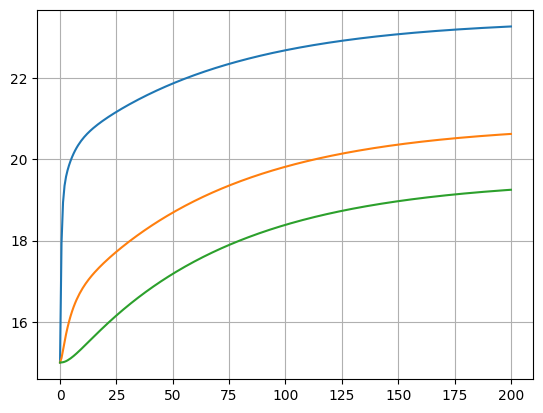

In [ ]:
T=np.linspace(0,200,300)

x0=np.array([15,15,15])

U=np.array([30+0*T,15+0*T]).T

te=[]
for i in range(3):
  lti=signal.StateSpace(A,B,np.eye(A.shape[0])[i],np.array([[0,0]]))
  t_, y ,k= signal.lsim(lti,T=T,X0=x0,U=U)
  te.append((i,np.max(y)))
  plt.plot(t_, y)
  plt.grid()
plt.show()

In [ ]:
for i in te:
  if i[1]>20:
    print(f"La habitación {i[0]} debe reducir la temperatura con {i[1]}")

La habitación 0 debe reducir la temperatura con 23.267980039156257
La habitación 1 debe reducir la temperatura con 20.62412285994375


In [1]:
from PIL import *

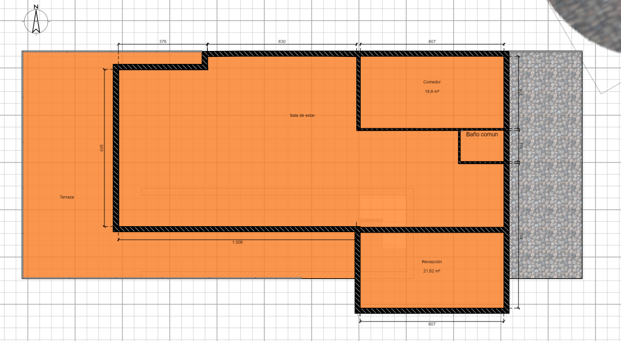

In [4]:
img=Image.open('cosa.PNG')
img=img.resize((621,341))
img

$p_{ij}$:pixel en la posicion i,j

$c_{ij}$:color del pixel en la posicion i,j

$V(p)$:Vector de posicion del pixel dado

$p_i$:Pixel iesimo del objeto

$A$:Objeto

$n$: valor de distancia maxima

$$p_{ij}\in A \iff \exists_{p}(p\in A \land d(p,p_{ij})\leq n \land c=c_{ij})$$

$$A_1\cup A_2 \equiv A_T \iff \exists_{xy}(x\in A_1 \land y\in A_2 \land d(x,y) \leq n)$$

In [11]:
dist=lambda A,B: pow(pow(A[0]-B[0],2)+pow(A[1]-B[1],2),1/2)#distancia de taxista

salto=1
tolerancia=5

class Nodo:
  def __init__(self,pixel:tuple):
    self.pixeles=[pixel]
    self.centro=None

  def pertenece(self,pixel):
    for i in range(0,len(self.pixeles),salto):
      if dist(self.pixeles[i],pixel)<tolerancia:
        self.agregar(pixel)
        return True
    return False
  
  def agregar(self,pixel):
    self.pixeles.append(pixel)

  def union(self,other):
    for i in other.pixeles:
      self.agregar(i)

def union(A:Nodo,B:Nodo):
  for i in range(0,len(A.pixeles),salto):
    for j in range(0,len(B.pixeles),salto):
      if dist(A.pixeles[i],A.pixeles[j])<tolerancia:
        A.union(B)
        B=None
        break

0 0


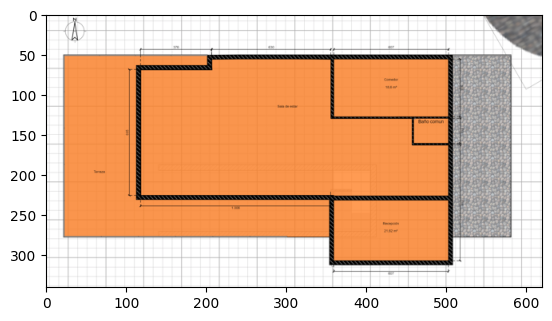

0 0


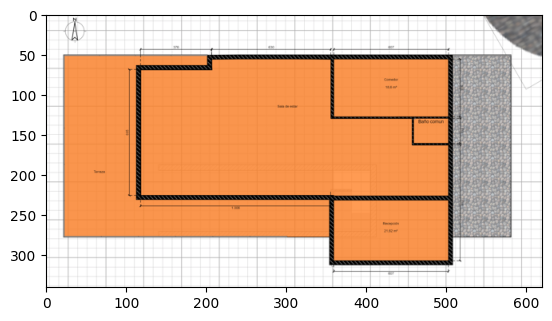

10 1


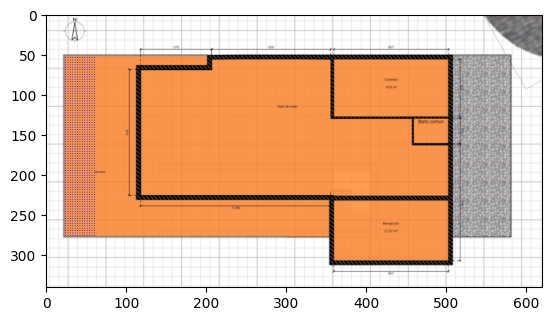

10 1


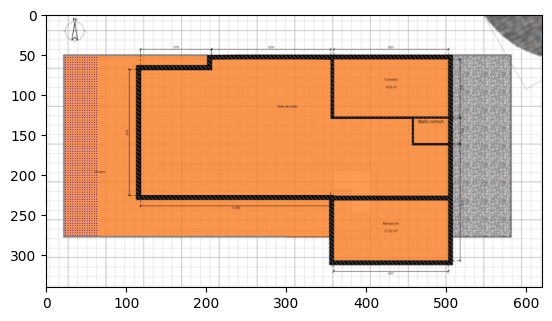

20 2


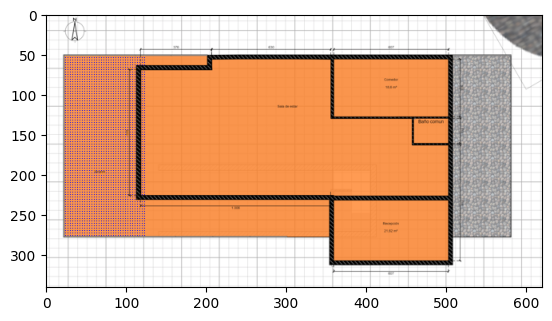

20 2


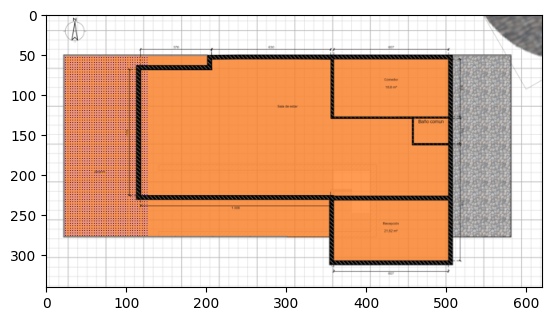

30 2


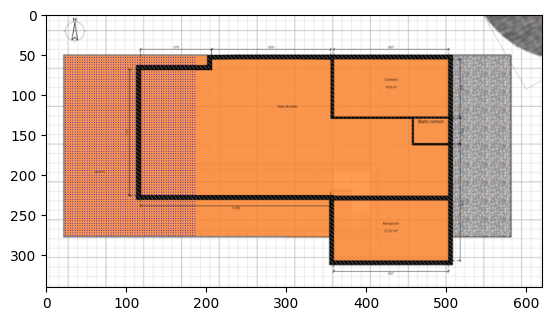

30 2


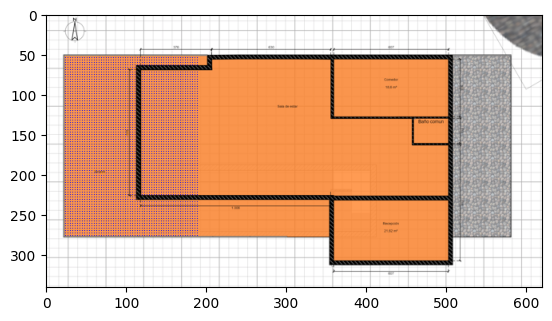

40 3


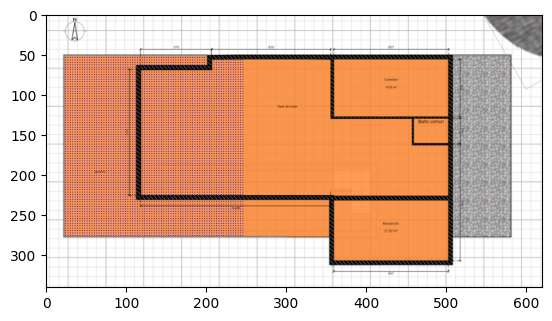

40 3


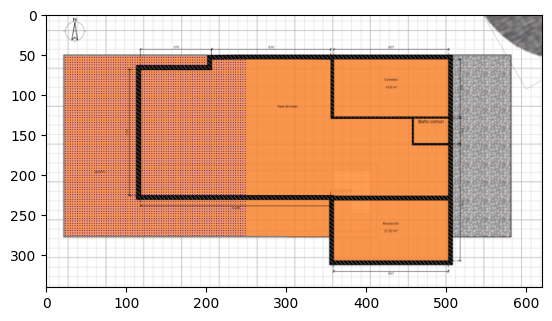

50 3


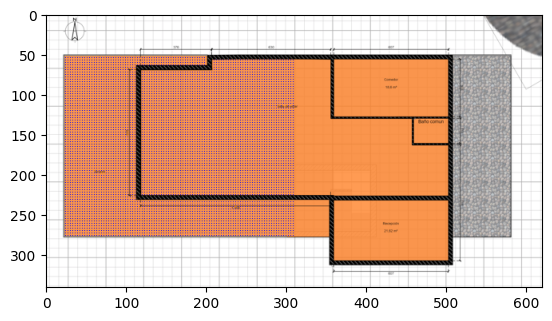

50 3


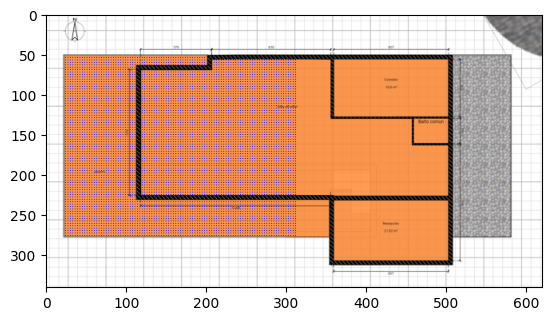

60 5


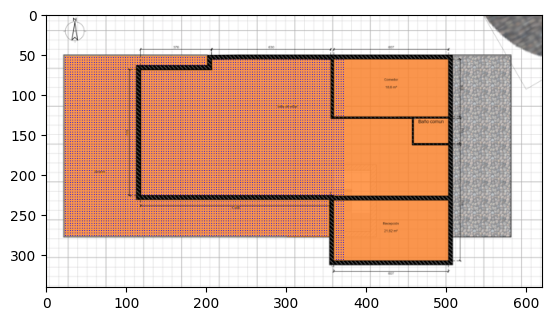

60 5


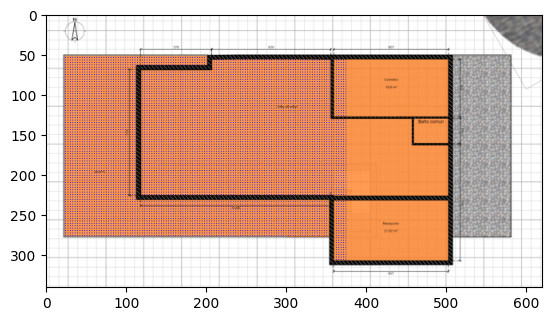

70 5


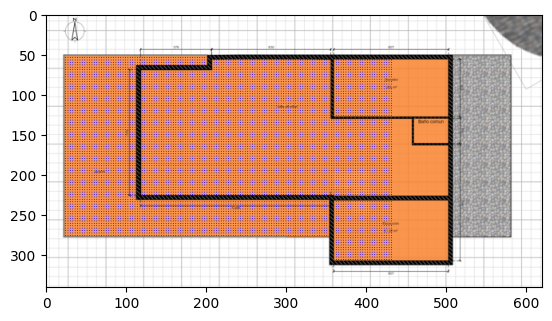

70 5


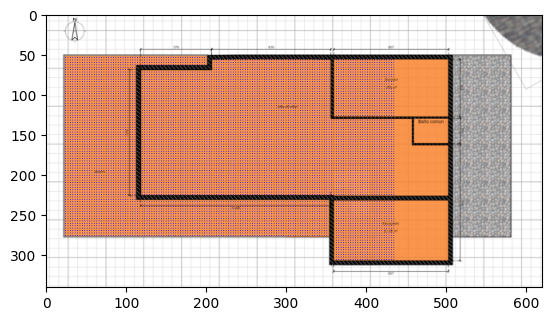

80 7


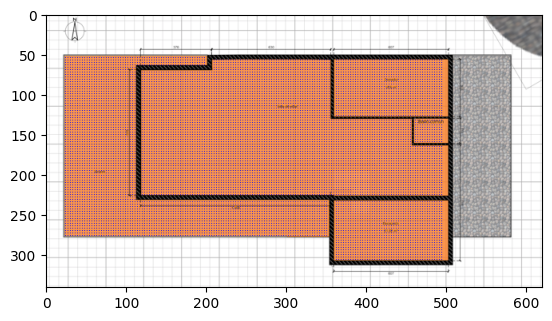

80 7


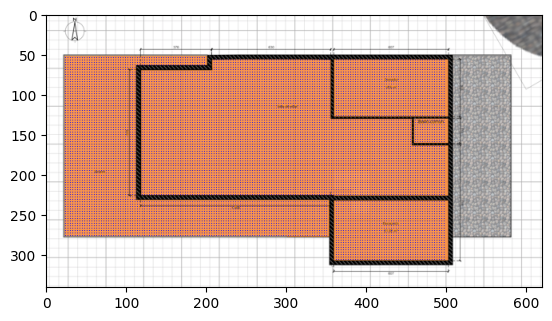

90 7


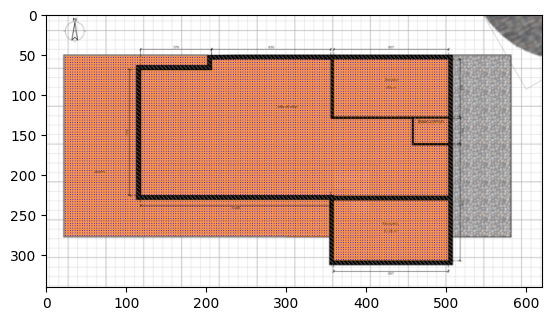

90 7


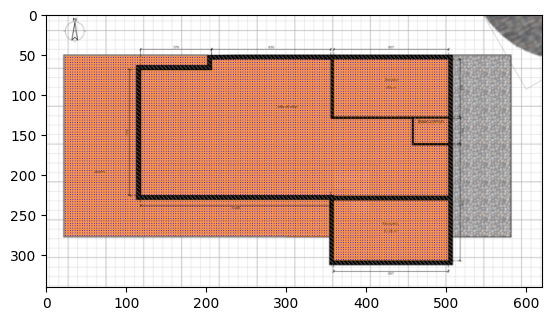

100 7


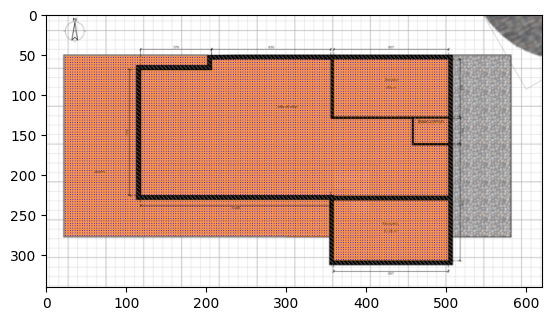

In [12]:
lo=[]
c=(250,149,77,255)
r=False
IM=img.copy()
for i in range(0,img.size[0],3):
  for j in range(0,img.size[1],3):
    if sum(abs(np.array(c)-np.array(img.getpixel((i,j)))))<=100:
      IM.putpixel((i,j),(0,0,255))
      for w in lo:
        r=w.pertenece([i,j])
        if r:
          break
      if not r:
        lo.append(Nodo([i,j]))
  if round(i/img.size[0]*100)%10==0:
    print(round(i/img.size[0]*100), len(lo))
    plt.imshow(IM)
    plt.show()

In [13]:
i=0
while i<len(lo):
  if len(lo[i].pixeles)<20:
    lo.pop(i)
    continue
  i+=1

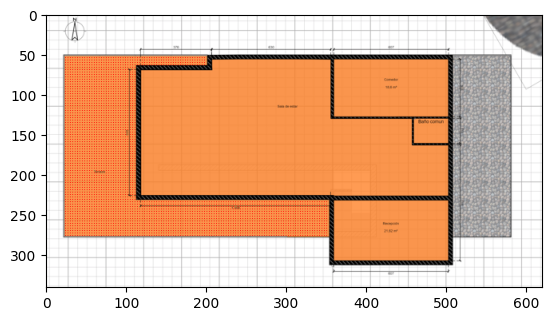

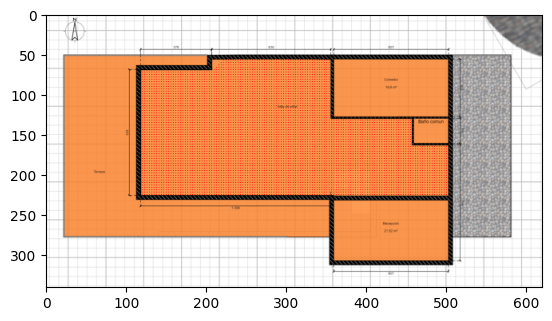

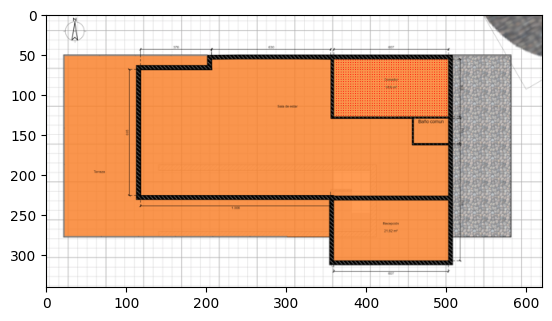

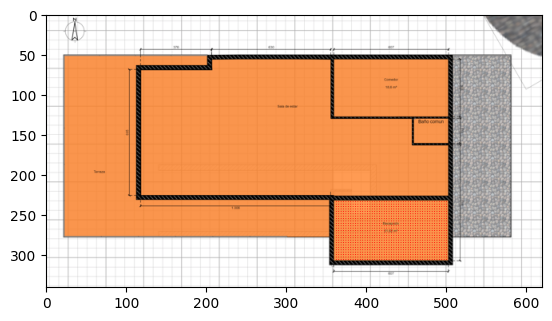

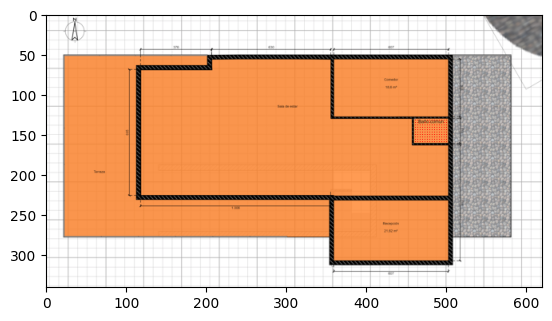

In [14]:
for j in lo:
  im=img.copy()
  for i in j.pixeles:
    im.putpixel(i,(255,0,0))
  plt.imshow(im)
  plt.show()

In [15]:
len(lo)

5

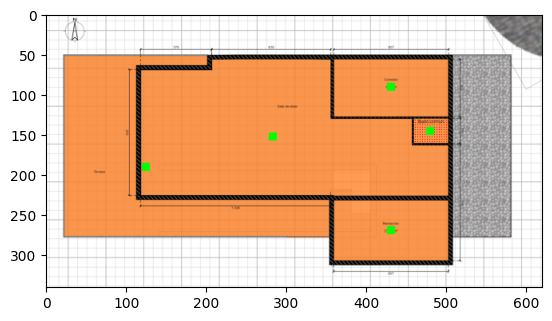

In [20]:
XY=[]
for k in range(len(lo)):
  XY.append(np.array(np.mean(lo[k].pixeles,axis=0),dtype='int64'))
  lo[k].centro=XY[-1]
  for i in range(XY[-1][0]-5,XY[-1][0]+5):
    for j in range(XY[-1][1]-5,XY[-1][1]+5):
      im.putpixel((i,j),(0,255,0))
plt.imshow(im)

In [21]:
for i in range(len(lo)-1):
  for j in range(i+1,len(lo)):
    cond=False
    for w in range(0,len(lo[i].pixeles),25):
      for k in range(0,len(lo[j].pixeles),25):
        if dist(lo[i].pixeles[w],lo[j].pixeles[k])<40:
          print(f"{lo[i].centro} conecta con {lo[j].centro}")
          cond=True
          break
      if cond:
        break

[125 191] conecta con [284 153]
[125 191] conecta con [432 270]
[284 153] conecta con [432  91]
[284 153] conecta con [432 270]
[284 153] conecta con [481 146]
[432  91] conecta con [481 146]
